<a href="https://colab.research.google.com/github/Mohammed-Hatem/mnist-linear-and-deep/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning — Assignment 2

##  Team Members
- **Mohammed Hatem**
- **Ahmed Ayman**
- **Joseph Yousery**

### ***Part A: Linear Classification Models***

#Neural Network

#Data Preperation

In [31]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split


# ====== Device ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

tran = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data_full = datasets.MNIST(root='./data', train=True, download=True, transform=tran)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=tran)

#split the train into 75% train 25% validation
train_size = int(0.75 * len(train_data_full))
val_size = len(train_data_full) - train_size
train_data, val_data = random_split(train_data_full, [train_size, val_size])


loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
}

print("Train batches:", len(loaders['train']))
print("Validation batches:", len(loaders['val']))
print("Test batches:", len(loaders['test']))


Using device: cpu
Train batches: 704
Validation batches: 235
Test batches: 157


# B1 Model creation

In [32]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



class Model(nn.Module):
  def __init__(self, inp_size = (28*28), h1 = 256, h2=128,classes = 10):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(inp_size, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, classes)

    for layer in [self.fc1, self.fc2, self.out]:
      nn.init.xavier_uniform_(layer.weight)
      nn.init.zeros_(layer.bias)

  def forward(self, x):
    x  = x.view(x.size(0), -1) #flatten the images into [64,784]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x) #logits
    return x


model = Model()
print(model)




Model(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)


# B2. Training Infrastructure

In [36]:
epochs  = 100
lr = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

#accuracy helper function

def accuracy(preds,labels):
  return (preds.argmax(1) == labels).float().mean()

train_losses, val_losses,train_accs, val_accs = [], [],[], []

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0


for epoch in range (epochs):
  model.train()
  train_loss = 0.0
  train_acc = 0.0

  for images, labels in loaders['train']:
    images, labels = images.to(device), labels.to(device)

    #forward
    logits = model(images)
    loss = criterion(logits, labels)


    #backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #metrics
    train_loss += loss.item() * images.size(0)
    train_acc += accuracy(logits, labels).item() * images.size(0)


  #validation
  model.eval()
  val_loss = 0.0
  val_acc = 0.0

  for images, labels in loaders['val']:
    images, labels = images.to(device), labels.to(device)
    logits = model(images)
    loss = criterion(logits, labels)
    val_loss += loss.item() * images.size(0)
    val_acc += accuracy(logits, labels).item() * images.size(0)


  #normalize and append
  train_losses.append(train_loss/len(loaders['train'].dataset))
  val_losses.append(val_loss/len(loaders['val'].dataset))
  train_accs.append(train_acc/len(loaders['train'].dataset))
  val_accs.append(val_acc/len(loaders['val'].dataset))


  print(f"Epoch {epoch+1:02d}/{epochs} | "
      f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
      f"Train Acc: {train_accs[-1]*100:.2f}% | Val Acc: {val_accs[-1]*100:.2f}%")

  # Early stopping check
  if val_losses[-1] < best_val_loss:
      best_val_loss = val_losses[-1]
      epochs_no_improve = 0
  else:
      epochs_no_improve += 1
      if epochs_no_improve == patience:
          print(f"Early stopping at epoch {epoch+1}")
          break

Epoch 01/100 | Train Loss: 0.5265 | Val Loss: 0.3683 | Train Acc: 85.70% | Val Acc: 89.27%
Epoch 02/100 | Train Loss: 0.3139 | Val Loss: 0.3131 | Train Acc: 90.81% | Val Acc: 90.70%
Epoch 03/100 | Train Loss: 0.2660 | Val Loss: 0.2595 | Train Acc: 92.32% | Val Acc: 92.55%
Epoch 04/100 | Train Loss: 0.2345 | Val Loss: 0.2320 | Train Acc: 93.31% | Val Acc: 93.12%
Epoch 05/100 | Train Loss: 0.2108 | Val Loss: 0.2575 | Train Acc: 93.93% | Val Acc: 91.91%
Epoch 06/100 | Train Loss: 0.1910 | Val Loss: 0.2583 | Train Acc: 94.58% | Val Acc: 91.91%
Epoch 07/100 | Train Loss: 0.1751 | Val Loss: 0.1839 | Train Acc: 95.04% | Val Acc: 94.50%
Epoch 08/100 | Train Loss: 0.1613 | Val Loss: 0.2493 | Train Acc: 95.35% | Val Acc: 91.67%
Epoch 09/100 | Train Loss: 0.1496 | Val Loss: 0.2182 | Train Acc: 95.73% | Val Acc: 93.24%
Epoch 10/100 | Train Loss: 0.1390 | Val Loss: 0.1538 | Train Acc: 96.02% | Val Acc: 95.39%
Epoch 11/100 | Train Loss: 0.1299 | Val Loss: 0.1553 | Train Acc: 96.32% | Val Acc: 95.43%

#B3 Performance visualization

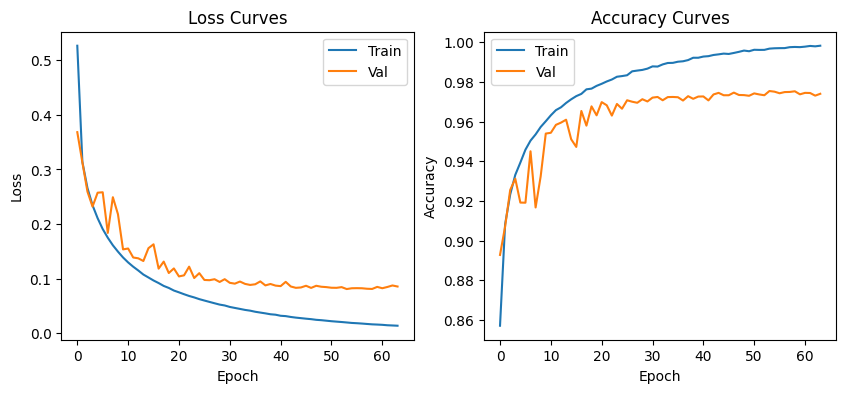

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves"); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curves"); plt.legend()
plt.show()


# Test evaluation

Test Accuracy: 97.61%


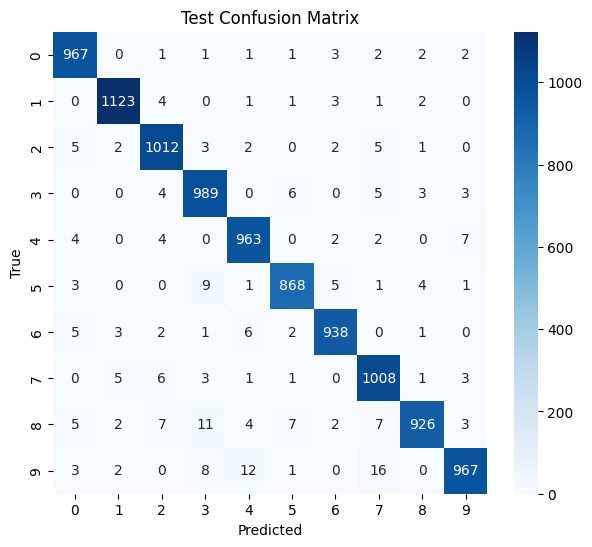

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in loaders['test']:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

acc = (all_preds == all_labels).float().mean().item()
print(f"Test Accuracy: {acc*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Test Confusion Matrix")
plt.show()
